In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import pandas as pd
import numpy as np
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

from categorical import one_hot_encode_categorical
from feature_nlp import nlp
from feature_numerical import process_numerical_columns
from location_preprocessing import get_locations_features
from feature_date import cyclical_encode_dates
from parse_amenities import parse_amenities

In [90]:
df = pd.read_csv("Airbnb_Data.csv")
print(df.shape)
df.head()

(74111, 29)


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [91]:
df.set_index('id', inplace=True)
df.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [92]:
df_amenities_count = parse_amenities(df)
print(df_amenities_count.shape)
df_amenities_count.head()

(74111, 1)


,amenities_count
id,
6901257,-1.242623
6304928,-0.375379
7919400,0.202783
13418779,-0.375379
3808709,-0.809001


In [93]:
df_categorical = one_hot_encode_categorical(df)
print(df_categorical.shape)
df_categorical.head()

/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


(74111, 8)


,property_type,room_type,bed_type,cancellation_policy,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable
id,,,,,,,,
6901257,-0.895236,0.084208,-0.442722,-0.038795,1,1,1,0
6304928,-0.895236,0.084208,-0.442722,-0.038795,1,1,0,1
7919400,-0.521245,-0.618787,0.454673,0.709744,1,1,1,1
13418779,-0.008698,0.176991,1.109309,-0.919058,1,1,1,0
3808709,-0.521245,-0.618787,0.454673,0.709744,1,1,1,1


In [94]:
df_categorical.columns

Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
       'instant_bookable'],
      dtype='object')

In [95]:
df_nlp = nlp(df)
print(df_nlp.shape)
df_nlp.head()

(74111, 30)


,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,amenities_count,keywords_combined,description_polarity,description_subjectivity
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,-1.242623,"brownstone, brooklyn, beautiful, stunning, bridge",0.750000,0.937500
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,-0.375379,"times, place, square, centrally, located",0.297500,0.512083
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,0.202783,"unit, backyard, lighting, total, entire",0.274085,0.512857
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,-0.375379,"haight, super, away, trendy, street",0.301186,0.553205
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,4,40.0,NaN,20009,0.0,1.0,-0.809001,"tons, metro, diverse, different, columbia",0.239881,0.495833


In [96]:
df_numerical = process_numerical_columns(df)
print(df_numerical.shape)
df_numerical.head()

/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer w

(74111, 11)


/Users/chrystalquek/opt/anaconda3/envs/aml/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,accommodates,number_of_reviews,beds_per_bedroom,beds,bedrooms,bed_and_bathrooms,bathrooms,host_response_rate,host_response_rate_normalized,review_scores_rating,review_scores_rating_normalized
id,,,,,,,,,,,
6901257,3,2,0.500000,1.0,1.0,0.003673,1.0,94.351967,0.000000,100.000000,0.058284
6304928,7,6,0.750000,3.0,3.0,0.003673,1.0,100.000000,0.398271,93.000000,0.055619
7919400,5,10,1.500000,3.0,1.0,0.003673,1.0,100.000000,0.398271,92.000000,0.055222
13418779,4,0,0.666667,2.0,2.0,0.003673,1.0,94.351967,0.000000,95.273438,0.056505
3808709,2,4,1.000000,1.0,0.0,0.003673,1.0,100.000000,0.398271,40.000000,0.024828


In [97]:
df_numerical[df_numerical.isna().any(axis=1)]

,accommodates,number_of_reviews,beds_per_bedroom,beds,bedrooms,bed_and_bathrooms,bathrooms,host_response_rate,host_response_rate_normalized,review_scores_rating,review_scores_rating_normalized
id,,,,,,,,,,,


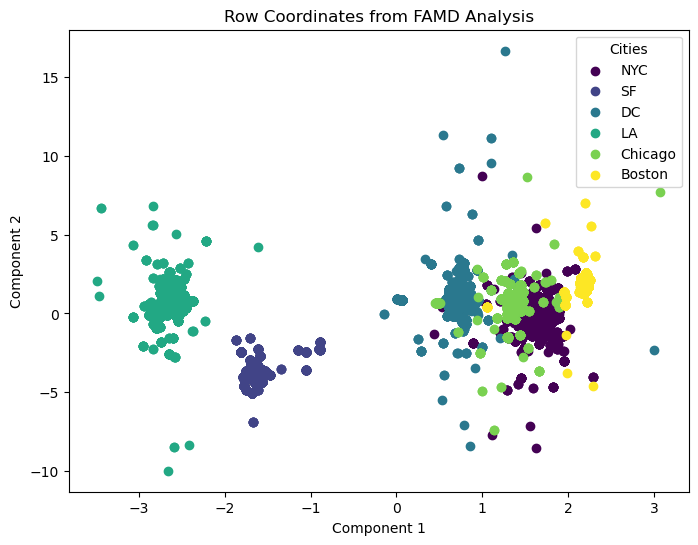

(74111, 3)


,location_component_0,location_component_1,city
id,,,
6901257,1.705783,-0.294103,NYC
6304928,1.660870,-0.234041,NYC
7919400,1.677362,-0.270865,NYC
13418779,-1.683706,-5.062434,SF
3808709,0.756076,0.332060,DC


In [98]:
df_locations  =  get_locations_features(df)
print(df_locations.shape)
df_locations.head()

In [99]:
df_locations.columns

Index(['location_component_0', 'location_component_1', 'city'], dtype='object')

In [100]:
df_datetime = cyclical_encode_dates(df)
print(df_datetime.shape)
df_datetime.head()

Missing rows in first_review: 15864
Missing rows in host_since: 188
Missing rows in last_review: 15827
(74111, 3)


/Users/chrystalquek/Documents/LastSemBestSem/DataScienceAssignments/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors will turn problematic parsing into NaT
/Users/chrystalquek/Documents/LastSemBestSem/DataScienceAssignments/dsw-project/feature_date.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce errors will turn problematic parsing into NaT
/Users

,first_review_days_since,host_since_days_since,last_review_days_since
id,,,
6901257,-0.353755,1.282186,1.166963e+00
6304928,-1.292354,-1.610406,-9.352288e-01
7919400,-1.071908,-1.251671,-8.914331e-01
13418779,0.000000,-0.411593,2.212884e-15
3808709,0.562118,-0.337424,2.521201e-01


In [101]:
all_data_df = pd.concat([
    df['log_price'],
    df_amenities_count,
    df_categorical[[
        'property_type', 'room_type', 'bed_type', 'cancellation_policy',
        'cleaning_fee', 'host_identity_verified',
        'instant_bookable']],
    df_nlp[['description_polarity', 'description_subjectivity']],
    df_numerical[['accommodates', 'beds_per_bedroom',
                  'bed_and_bathrooms', 'review_scores_rating_normalized', 'number_of_reviews']],
    df_locations[['location_component_0', 'location_component_1', 'city']],
    df_datetime
                         
                         ], axis=1)
print(all_data_df.shape)
all_data_df.head()

(74111, 22)


,log_price,amenities_count,property_type,room_type,bed_type,cancellation_policy,cleaning_fee,host_identity_verified,instant_bookable,description_polarity,...,beds_per_bedroom,bed_and_bathrooms,review_scores_rating_normalized,number_of_reviews,location_component_0,location_component_1,city,first_review_days_since,host_since_days_since,last_review_days_since
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,-1.242623,-0.895236,0.084208,-0.442722,-0.038795,1,1,0,0.750000,...,0.500000,0.003673,0.058284,2,1.705783,-0.294103,NYC,-0.353755,1.282186,1.166963e+00
6304928,5.129899,-0.375379,-0.895236,0.084208,-0.442722,-0.038795,1,0,1,0.297500,...,0.750000,0.003673,0.055619,6,1.660870,-0.234041,NYC,-1.292354,-1.610406,-9.352288e-01
7919400,4.976734,0.202783,-0.521245,-0.618787,0.454673,0.709744,1,1,1,0.274085,...,1.500000,0.003673,0.055222,10,1.677362,-0.270865,NYC,-1.071908,-1.251671,-8.914331e-01
13418779,6.620073,-0.375379,-0.008698,0.176991,1.109309,-0.919058,1,1,0,0.301186,...,0.666667,0.003673,0.056505,0,-1.683706,-5.062434,SF,0.000000,-0.411593,2.212884e-15
3808709,4.744932,-0.809001,-0.521245,-0.618787,0.454673,0.709744,1,1,1,0.239881,...,1.000000,0.003673,0.024828,4,0.756076,0.332060,DC,0.562118,-0.337424,2.521201e-01


In [102]:
print(all_data_df.dtypes)

log_price                          float64
amenities_count                    float64
property_type                      float64
room_type                          float64
bed_type                           float64
cancellation_policy                float64
cleaning_fee                        object
host_identity_verified              object
instant_bookable                    object
description_polarity               float64
description_subjectivity           float64
accommodates                         int64
beds_per_bedroom                   float64
bed_and_bathrooms                  float64
review_scores_rating_normalized    float64
number_of_reviews                    int64
location_component_0               float64
location_component_1               float64
city                                object
first_review_days_since            float64
host_since_days_since              float64
last_review_days_since             float64
dtype: object


In [103]:
all_data_df.columns[all_data_df.isna().any()].tolist()

[]

In [104]:
all_data_df.shape

(74111, 22)

In [105]:
X = all_data_df.drop(['log_price', 'city'], axis=1).copy()
X = X.apply(pd.to_numeric)
# Convert boolean columns to integers if there are any
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)

y = all_data_df['log_price'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [106]:
model = LinearRegression()

In [107]:
model.fit(X_train, y_train)

LinearRegression()

In [108]:
# Make predictions using the testing set
y_pred = model.predict(X_test)

In [109]:
# The coefficients
# print('Coefficients:', model.coef_)

# Mean squared error
print('Mean squared error:', mean_squared_error(y_test, y_pred))

# Coefficient of determination (1 is perfect prediction)
print('Coefficient of determination:', r2_score(y_test, y_pred))

Mean squared error: 0.2572372706368478
Coefficient of determination: 0.49927135975033543


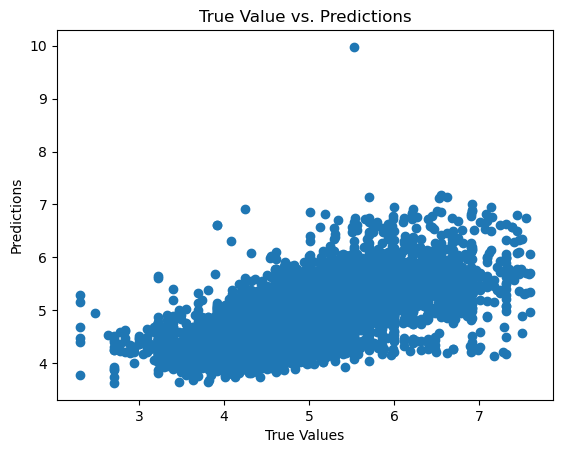

In [110]:
# Plotting for visualization
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Value vs. Predictions')
plt.show()

In [111]:
# Add a constant to the features for the intercept
X_with_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y,X_with_const).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     3763.
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        16:37:55   Log-Likelihood:                -54566.
No. Observations:               74111   AIC:                         1.092e+05
Df Residuals:                   74090   BIC:                         1.094e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

# Fitting Linear Regression by City 

city:  Boston
Mean squared error: 0.19125421129940312
Coefficient of determination: 0.5738448097687872


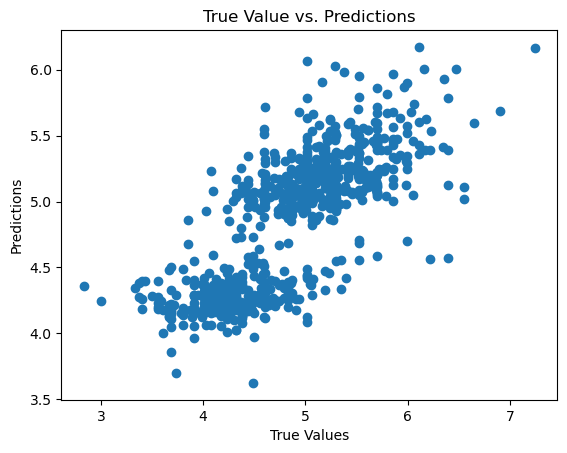

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     230.3
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        16:37:55   Log-Likelihood:                -2032.5
No. Observations:                3468   AIC:                             4107.
Df Residuals:                    3447   BIC:                             4236.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

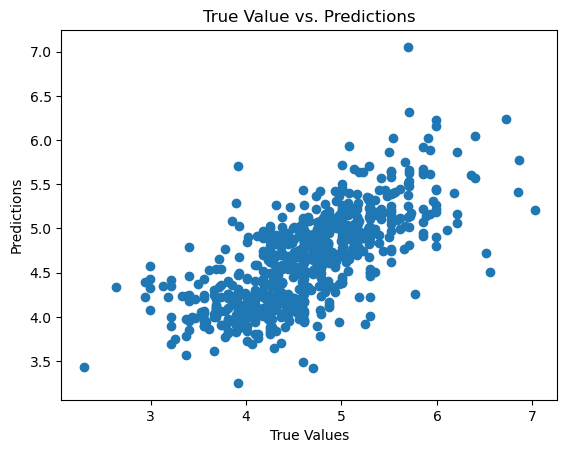

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     221.2
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        16:37:56   Log-Likelihood:                -2488.2
No. Observations:                3719   AIC:                             5018.
Df Residuals:                    3698   BIC:                             5149.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

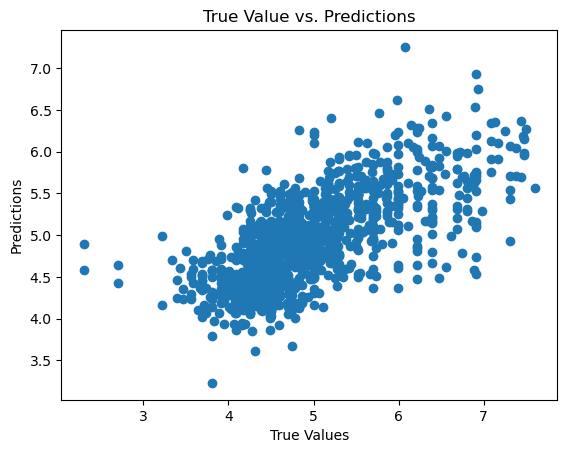

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     213.2
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        16:37:56   Log-Likelihood:                -5354.5
No. Observations:                5688   AIC:                         1.075e+04
Df Residuals:                    5667   BIC:                         1.089e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

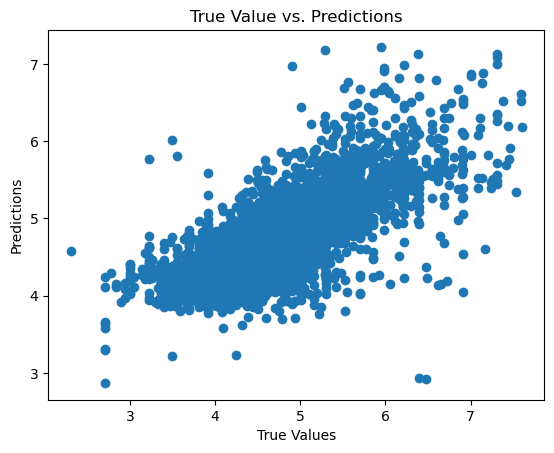

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     1360.
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        16:37:56   Log-Likelihood:                -16160.
No. Observations:               22453   AIC:                         3.236e+04
Df Residuals:                   22432   BIC:                         3.253e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

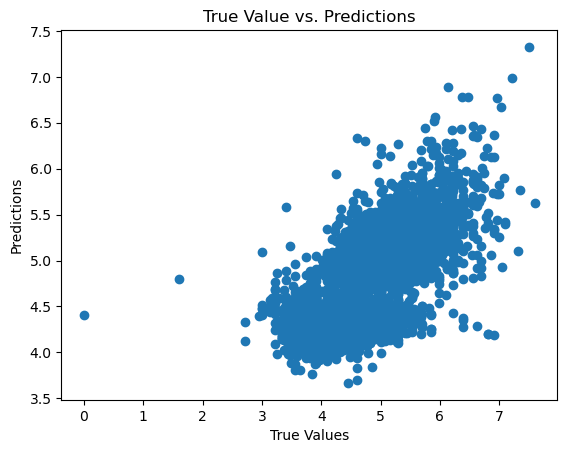

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     1666.
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        16:37:57   Log-Likelihood:                -21077.
No. Observations:               32349   AIC:                         4.220e+04
Df Residuals:                   32328   BIC:                         4.237e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

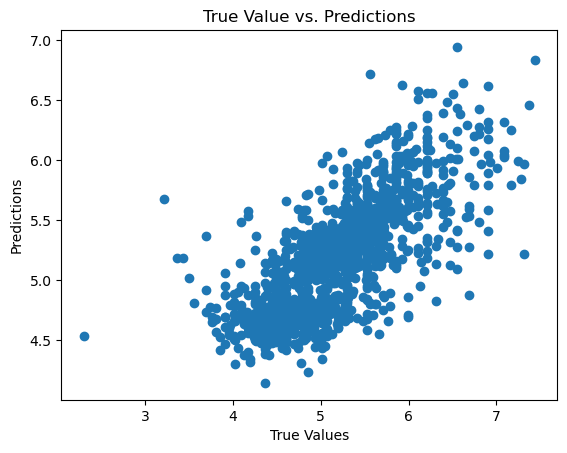

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     364.4
Date:                Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                        16:37:57   Log-Likelihood:                -4200.7
No. Observations:                6434   AIC:                             8443.
Df Residuals:                    6413   BIC:                             8586.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [112]:
for city in ['Boston', 'Chicago', 'DC', 'LA', 'NYC', 'SF']:
    print("city: ", city)
    city_df = all_data_df[all_data_df['city'] == city].reset_index(drop=True)
    X = city_df.copy()
    X.drop(['city', 'log_price'], axis=1, inplace=True)
    X = X.apply(pd.to_numeric)
    # Convert boolean columns to integers if there are any
    for col in X.columns:
        if X[col].dtype == bool:
            X[col] = X[col].astype(int)
    y = city_df['log_price']

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Mean squared error
    print('Mean squared error:', mean_squared_error(y_test, y_pred))

    # Coefficient of determination (1 is perfect prediction)
    print('Coefficient of determination:', r2_score(y_test, y_pred))
    # Plotting for visualization
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True Value vs. Predictions')
    plt.show()
    # Add a constant to the features for the intercept
    X_with_const = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X_with_const).fit()

    # Print the summary
    print(model.summary())